# take a video on webcam

```
cd ../src/utils
python save_img.py
```

# Extract Frames from Video File

In [1]:
from pathlib import Path


save_dir = Path('../data/target/')
try: 
    save_dir.mkdir(exist_ok=True)
except FileExistsError : 
    print("Directory exists. Abort creation")
    


img_dir = save_dir.joinpath('images')
try:
    img_dir.mkdir(exist_ok=True)
except FileExostsError:
    print("Directory exists. Abort creation")

In [1]:
import cv2 
import numpy as np

def extract_images_from_video(filepath, subsample =  1):
    """
    filepath: string
        file path to video.
    subsample: int 
        use only one of subsample images.
        subsample = 1, use all images.
    
    """
    
    print("Video path: ",str(save_dir.joinpath(filepath)))
    cap = cv2.VideoCapture(str(save_dir.joinpath(filepath)))
    crop = True
    i = 0
    j = 0
    flag = None
    while(cap.isOpened()):
        #Extract only 1 of subsample images
        flag, frame = cap.read()
        if flag == False:
            break
        if j%subsample == 0:

            # Crop images to desired size 
            if crop:
                frame = frame[355:-10,645:-645,:]
            #frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

            #if i >= 10:
            #    break

            cv2.imwrite(str(img_dir.joinpath('img_{:05d}.png'.format(i))), frame)
            i += 1


        j+= 1
    print("Number of frames:", i)

# Pose estimation (OpenPose)

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from pathlib import Path

%matplotlib inline

In [3]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')



### Autorelaod modules 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [7]:
weight_name = openpose_dir.joinpath('network/weight/pose_model.pth')

model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()

Bulding VGG19


DataParallel(
  (module): rtpose_model(
    (model0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kerne

## check

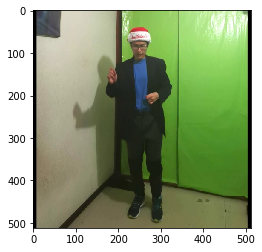

In [11]:
img_path = sorted(img_dir.iterdir())[0]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

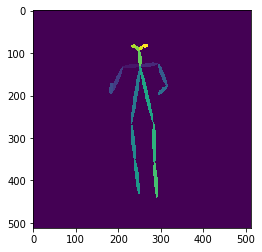

In [13]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label,cord  = get_pose(param, heatmap, paf)

plt.imshow(label)

## make label images for pix2pix

In [17]:

train_dir = save_dir.joinpath('train')
try:
    train_dir.mkdir(exist_ok=True)
except FileExistsError:
    print("Directory exists. Abort creation")
    

train_img_dir = train_dir.joinpath('train_img')
try:
    train_img_dir.mkdir(exist_ok=True)
except FileExistsError:
    print("Directory exists. Abort creation")

    

train_label_dir = train_dir.joinpath('train_label')
try:
    train_label_dir.mkdir(exist_ok=True)   
except FileExistsError:
    print("Directory exists. Abort creation")
    

train_head_dir = train_dir.joinpath('head_img')
try:
    train_head_dir.mkdir(exist_ok=True)
except FileExistsError:
    print("Directory exists. Abort creation")
    
    
import os

NUM_FRAMES = len(os.listdir(str(img_dir)))

pose_cords = []
for idx in tqdm(range(20)):
    img_path = img_dir.joinpath('img_{:05d}.png'.format(idx))
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label, cord = get_pose(param, heatmap, paf)
    index = 13
    crop_size = 25
    try:
        head_cord = cord[index]
    except:
        head_cord = pose_cords[-1] # if there is not head point in picture, use last frame

    pose_cords.append(head_cord)
    head = img[int(head_cord[1] - crop_size): int(head_cord[1] + crop_size),
           int(head_cord[0] - crop_size): int(head_cord[0] + crop_size), :]
    plt.imshow(head)
    plt.savefig(str(train_head_dir.joinpath('pose_{}.jpg'.format(idx))))
    plt.clf()
    
    cv2.imwrite(str(train_img_dir.joinpath('img_{:05d}.png'.format(idx))), img)    
    cv2.imwrite(str(train_label_dir.joinpath('label_{:05d}.png'.format(idx))), label)

    
pose_cords = np.array(pose_cords, dtype=np.int)
np.save(str((save_dir.joinpath('pose.npy'))), pose_cords)
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.97s/it]


<Figure size 432x288 with 0 Axes>